In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import datetime
import getpass

import cx_Oracle

class DbOra:
    
    connstr = '{username}/{password}@{hostname}:{port}/{database}'
#     oracle_connection_string = 'oracle+cx_oracle://' + \
#         '{username}:{password}@{hostname}:{port}/{database}'

    def __init__(self, username, password, hostname, sid, port=1521):
        self._username = username
        self._hostname = hostname
        self._sid = sid
        self._port = port
        self._connection = cx_Oracle.connect(
            DbOra.connstr.format(
                username=username,
                password=password,
                hostname=hostname,
                port=port,
                database=sid
            )
        )
        self._cursor = self._connection.cursor()
        self._cursor.arraysize = 50000
        
    @property
    def cursor(self):
        return self._cursor
    
    def stage_data(self, name, cnames, data):
        map_dtype_to_oratype = {
            str: 'VARCHAR2(256)',
            int: 'NUMBER',
            float: 'NUMBER',
            datetime.datetime: 'DATE'
        }
        ora_types = [map_dtype_to_oratype[type(x)] for x in data[0]]
        cols_str = ', '.join(['%s %s'%(cname, oratype)
                             for cname, oratype in zip(cnames, ora_types)])
        sql_create = 'create global temporary table %s (%s) on commit preserve rows'%(name, cols_str)
#         sql_create = 'create table %s (%s)'%(name, cols_str)
        
        ncols = len(data[0])
        bind_vars_str = ', '.join([':%d'%(i+1) for i in range(ncols)])
        sql_load = 'insert into %s (%s) values (%s)'%(name, ', '.join(list(cnames)), bind_vars_str)
        try:
            self._cursor.execute(sql_create)
        except cx_Oracle.DatabaseError as dberr:
            error, = dberr.args
            if error.code == 955:
                pass
            else:
                raise
        self._cursor.prepare(sql_load)
        self._cursor.executemany(None, data)
        
    def execute(self, sql):
        self._cursor.execute(sql)
            
    def query(self, sql):
        self._cursor.execute(sql)
        for rec in self._cursor:
            yield rec
            
    def get_column_names(self):
        return [x[0] for x in self._cursor.description]
        
    def commit(self):
        self._connection.commit()
        
    def rollback(self):
        self._connection.rollback()

    def __del__(self):
        self._connection.rollback()
        self._connection.close()

In [3]:
password_cdw = getpass.getpass('CDW Password:')

CDW Password:········


In [5]:
def get_cohort_ts():
    db_cdw = DbOra('ephelps', password_cdw,
                   'hssc-cdwr3-dtdb-p', 'dtprd2')
    sql = '''
        select /*+ parallel 4 */
          count(distinct stroke.patient_id),
          count(distinct proc.patient_id),
          cast(proc.visit_start_date-stroke.visit_start_date as INT) n_days
        from (
            select
                enc.patient_id,
                enc.visit_id,
                enc.visit_start_date
            from cdw.visit enc
            where enc.datasource_id in (1, 14, 25, 140)
              and enc.visit_id in (
                select distinct
                    visit_id
                from cdw.diagnosis dx
                where dx.dx_code like '433.%1' or dx.dx_code like '434.%1' or dx.dx_code like '436%'
                   or dx.dx_code in ('I63.9', 'I63.231', 'I63.512', 'I63.511', 'I63.522', 'I63.521',
                                     'I63.531', 'I63.532', 'I63.29', 'I63.22', 'I63.529', 'I63.539', 'I63.8')
              )
        ) stroke
        left outer join (
            select
                enc.patient_id,
                enc.visit_id,
                px.proc_code,
                px.proc_start_date,
                enc.visit_start_date
            from cdw.visit enc
            inner join cdw.procedure px on ( enc.visit_id = px.visit_id )
            where enc.datasource_id in (1, 14, 25, 140)
              and px.proc_code_type like 'CPT%'
              and LENGTH(TRIM(TRANSLATE(px.proc_code, '0123456789',' '))) is null
              and (   (to_number(px.proc_code) between 10021 and 10022)
                   or (to_number(px.proc_code) between 10030 and 19499)
                   or (to_number(px.proc_code) between 20005 and 29999)
                   or (to_number(px.proc_code) between 30000 and 32999)
                   or (to_number(px.proc_code) between 38100 and 38999)
                   or (to_number(px.proc_code) between 39000 and 39599)
                   or (to_number(px.proc_code) between 40490 and 49999)
                   or (to_number(px.proc_code) between 50010 and 53899)
                   or (to_number(px.proc_code) between 54000 and 55899)
                   or (to_number(px.proc_code) between 55920 and 55920)
                   or (to_number(px.proc_code) between 55970 and 55980)
                   or (to_number(px.proc_code) between 56405 and 58999)
                   or (to_number(px.proc_code) between 60000 and 60699)
                   or (to_number(px.proc_code) between 61000 and 64999)
                   or (to_number(px.proc_code) between 65091 and 68899)
                   or (to_number(px.proc_code) between 69000 and 69979)
                   or (to_number(px.proc_code) between 69990 and 69990)
                  )
        ) proc on (     stroke.patient_id = proc.patient_id
                    and stroke.visit_start_date < proc.visit_start_date
                    and stroke.visit_start_date + 365 > proc.visit_start_date
                  )
        group by cast(proc.visit_start_date-stroke.visit_start_date as INT)
        order by 3
    '''
#     ('MUSC_MED_OP', 'MUSC_NDC')
    retval = list(db_cdw.query(sql))
    del db_cdw
    return retval

In [6]:
resp = get_cohort_ts()

In [7]:
resp[0:10]

[(83, 83, 0),
 (13, 13, 1),
 (16, 16, 2),
 (11, 11, 3),
 (10, 10, 4),
 (14, 14, 5),
 (19, 19, 6),
 (21, 21, 7),
 (18, 18, 8),
 (14, 14, 9)]

In [15]:
resp2 = [(y,z//5+2.5) for (x,y,z) in resp if z is not None and z>0]
X,Y = zip(*resp2)

In [16]:
from collections import Counter

cntr = Counter()
for x,y in zip(X,Y):
    cntr[y] += x

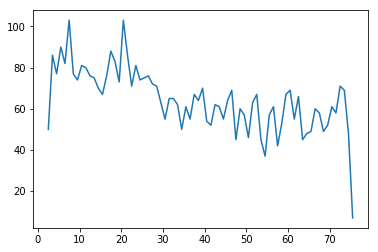

In [22]:
plt.plot(cntr.keys(), cntr.values())

```
select /*+ parallel 4 */
    count(1) n_encs,
    count(distinct patient_id) n_pats
from cdw.visit enc
where enc.visit_id in (
    select distinct
        visit_id
    from cdw.diagnosis dx
    where dx.dx_code like '433.%1' or dx.dx_code like '434.%1' or dx.dx_code like '436%'
       or dx.dx_code in ('I63.9', 'I63.231', 'I63.512', 'I63.511', 'I63.522', 'I63.521',
                         'I63.531', 'I63.532', 'I63.29', 'I63.22', 'I63.529', 'I63.539', 'I63.8')
  ) and enc.datasource_id in (1, 14, 25, 140)
;
--53187	24636

select /*+ parallel 4 */
  count(distinct stroke.visit_id), count(distinct stroke.patient_id),
  count(distinct proc.visit_id), count(distinct proc.patient_id)
from (
    select
        enc.patient_id,
        enc.visit_id,
        enc.visit_start_date
    from cdw.visit enc
    where enc.datasource_id in (1, 14, 25, 140)
      and enc.visit_id in (
        select distinct
            visit_id
        from cdw.diagnosis dx
        where dx.dx_code like '433.%1' or dx.dx_code like '434.%1' or dx.dx_code like '436%'
           or dx.dx_code in ('I63.9', 'I63.231', 'I63.512', 'I63.511', 'I63.522', 'I63.521',
                             'I63.531', 'I63.532', 'I63.29', 'I63.22', 'I63.529', 'I63.539', 'I63.8')
      )
) stroke
left outer join (
    select
        enc.patient_id,
        enc.visit_id,
        px.proc_code,
        px.proc_start_date,
        enc.visit_start_date
    from cdw.visit enc
    inner join cdw.procedure px on ( enc.visit_id = px.visit_id )
    where enc.datasource_id in (1, 14, 25, 140)
      and px.proc_code_type like 'CPT%'
      and LENGTH(TRIM(TRANSLATE(px.proc_code, '0123456789',' '))) is null
      and (   (to_number(px.proc_code) between 10021 and 10022)
           or (to_number(px.proc_code) between 10030 and 19499)
           or (to_number(px.proc_code) between 20005 and 29999)
           or (to_number(px.proc_code) between 30000 and 32999)
           or (to_number(px.proc_code) between 38100 and 38999)
           or (to_number(px.proc_code) between 39000 and 39599)
           or (to_number(px.proc_code) between 40490 and 49999)
           or (to_number(px.proc_code) between 50010 and 53899)
           or (to_number(px.proc_code) between 54000 and 55899)
           or (to_number(px.proc_code) between 55920 and 55920)
           or (to_number(px.proc_code) between 55970 and 55980)
           or (to_number(px.proc_code) between 56405 and 58999)
           or (to_number(px.proc_code) between 60000 and 60699)
           or (to_number(px.proc_code) between 61000 and 64999)
           or (to_number(px.proc_code) between 65091 and 68899)
           or (to_number(px.proc_code) between 69000 and 69979)
           or (to_number(px.proc_code) between 69990 and 69990)
          )
) proc on (     stroke.patient_id = proc.patient_id
            and stroke.visit_start_date < proc.visit_start_date
            and stroke.visit_start_date + 365 > proc.visit_start_date
          )
;
--53187	24636	3027	1539

select /*+ parallel 4 */
  count(distinct stroke.patient_id), count(distinct proc.patient_id), cast(proc.visit_start_date-stroke.visit_start_date as INT) n_days
from (
    select
        enc.patient_id,
        enc.visit_id,
        enc.visit_start_date
    from cdw.visit enc
    where enc.datasource_id in (1, 14, 25, 140)
      and enc.visit_id in (
        select distinct
            visit_id
        from cdw.diagnosis dx
        where dx.dx_code like '433.%1' or dx.dx_code like '434.%1' or dx.dx_code like '436%'
           or dx.dx_code in ('I63.9', 'I63.231', 'I63.512', 'I63.511', 'I63.522', 'I63.521',
                             'I63.531', 'I63.532', 'I63.29', 'I63.22', 'I63.529', 'I63.539', 'I63.8')
      )
) stroke
left outer join (
    select
        enc.patient_id,
        enc.visit_id,
        px.proc_code,
        px.proc_start_date,
        enc.visit_start_date
    from cdw.visit enc
    inner join cdw.procedure px on ( enc.visit_id = px.visit_id )
    where enc.datasource_id in (1, 14, 25, 140)
      and px.proc_code_type like 'CPT%'
      and LENGTH(TRIM(TRANSLATE(px.proc_code, '0123456789',' '))) is null
      and (   (to_number(px.proc_code) between 10021 and 10022)
           or (to_number(px.proc_code) between 10030 and 19499)
           or (to_number(px.proc_code) between 20005 and 29999)
           or (to_number(px.proc_code) between 30000 and 32999)
           or (to_number(px.proc_code) between 38100 and 38999)
           or (to_number(px.proc_code) between 39000 and 39599)
           or (to_number(px.proc_code) between 40490 and 49999)
           or (to_number(px.proc_code) between 50010 and 53899)
           or (to_number(px.proc_code) between 54000 and 55899)
           or (to_number(px.proc_code) between 55920 and 55920)
           or (to_number(px.proc_code) between 55970 and 55980)
           or (to_number(px.proc_code) between 56405 and 58999)
           or (to_number(px.proc_code) between 60000 and 60699)
           or (to_number(px.proc_code) between 61000 and 64999)
           or (to_number(px.proc_code) between 65091 and 68899)
           or (to_number(px.proc_code) between 69000 and 69979)
           or (to_number(px.proc_code) between 69990 and 69990)
          )
) proc on (     stroke.patient_id = proc.patient_id
            and stroke.visit_start_date < proc.visit_start_date
            and stroke.visit_start_date + 365 > proc.visit_start_date
          )
group by cast(proc.visit_start_date-stroke.visit_start_date as INT)
order by 3
;
```